In [1]:
import cv2
import os

import numpy as np
import pandas as pd

import albumentations
import joblib
import pretrainedmodels
import torch
import torch.nn as nn

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import shuffle
from sklearn import metrics

from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms, utils, models, datasets
from torchsummary import summary

from tqdm.notebook import tqdm



from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
TRAIN_CSV_PATH = "../data/train.csv"
STRATIFIED_CSV_PATH = "../data/stratified_train.csv"

TRAIN_IMG_PATH = "../train_images/"
COMBINED_IMAGE_PATH = "../data/"

TRAIN = ['../data/train_image_data_0.parquet',
         '../data/train_image_data_1.parquet',
         '../data/train_image_data_2.parquet',
         '../data/train_image_data_3.parquet']

TEST_CSV_PATH = "../data/test.csv"

FOLDS = 5 # Represents stratification folds
EPOCHS = 50 # number of iterations for running the model
TRAIN_BATCH_SIZE = 32 # batch size to train from train set
VALIDATION_BATCH_SIZE = 32 # batch size to validate from validation set

In [28]:
def generate_stratified_df():
    if os.path.exists(STRATIFIED_CSV_PATH):
        return pd.read_csv(STRATIFIED_CSV_PATH)
    else:
        df = pd.read_csv(TRAIN_CSV_PATH)
        print(df.shape)
        #Only used for testing purposes
        #df = df.sample(frac = 0.2, random_state=0)
        
        df.loc[:, 'kfold'] = -1
        df = df.sample(frac=1).reset_index(drop=True)
        x = df.image_id.values
        y = df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
        mskf = MultilabelStratifiedKFold(n_splits=FOLDS)
        
        for fold, (trn_, val_) in enumerate(mskf.split(x, y)):
            df.loc[val_, "kfold"] = fold

        df.to_csv(STRATIFIED_CSV_PATH, index=False)
        print(df.shape)
        return df

train_df = generate_stratified_df()
train_df.head()

(200840, 5)
(200840, 6)


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,kfold
0,Train_99692,75,2,0,দ্ধি,0
1,Train_119076,142,1,0,ষ্ঠা,0
2,Train_37123,117,6,0,ম্পৃ,0
3,Train_101986,18,4,0,ক্ষু,0
4,Train_45739,96,7,2,র্পে,3


In [4]:
def generate_images():
    if os.path.exists(TRAIN_IMG_PATH):
        return
    
    os.makedirs(TRAIN_IMG_PATH)
    for fname in TRAIN:
        df = pd.read_parquet(fname)
        image_ids = df.image_id.values
        df = df.drop("image_id", axis=1)
        image_array = df.values
        for j, image_id in tqdm(enumerate(image_ids), total=len(image_ids)):
            joblib.dump(image_array[j, :], TRAIN_IMG_PATH + image_id + ".pkl")

generate_images()            

In [5]:
class GraphemeDataset(Dataset):
    def __init__(self, label_df, augmentation=False):
        self.label_df = label_df
        if augmentation:
            self.transforms = albumentations.Compose([
                    albumentations.Resize(137, 236, always_apply=True),
                    albumentations.ShiftScaleRotate(shift_limit=0.0625,
                                               scale_limit=0.1, 
                                               rotate_limit=5,
                                               p=0.9),
                    albumentations.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225),
                                             always_apply=True)
                ])
        else:
            self.transforms = albumentations.Compose([
                    albumentations.Resize(137, 236, always_apply=True),
                    albumentations.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225),
                                             always_apply=True)
                ])
            
    
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self,idx):
        label1 = torch.tensor(self.label_df.grapheme_root.values[idx], dtype=torch.long)
        label2 = torch.tensor(self.label_df.vowel_diacritic.values[idx], dtype=torch.long)
        label3 = torch.tensor(self.label_df.consonant_diacritic.values[idx], dtype=torch.long)
        
        image = joblib.load(TRAIN_IMG_PATH + self.label_df.image_id.values[idx] + ".pkl")
        image = image.reshape(137,236).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.transforms(image=np.array(image))["image"]
            
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float) 
        return image,label1,label2,label3

In [6]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        
        # grapheme_root
        self.l0 = nn.Linear(512, 168)
        
        # vowel_diacritic
        self.l1 = nn.Linear(512, 11)
        
        # consonant_diacritic
        self.l2 = nn.Linear(512, 7)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        l1 = self.l1(x)
        l2 = self.l2(x)
        return l0, l1, l2

In [7]:
def run_model(model, optimizer, criterion, scheduler, 
              folds=5, epochs=20, train_batch_size=32, validation_batch_size=32):
    
    train_validate_df = generate_stratified_df()
    best_acc = 0.0
    train_losses = []
    train_recalls = []
    valid_losses = []
    valid_recalls = []
    final_train_outputs = final_train_targets = final_valid_outputs = final_valid_targets = None  
    for fold in range(folds):
        print('folds {}/{} '.format(fold+1,folds))
        
        train_df = train_validate_df[~train_validate_df.kfold.isin([fold])].reset_index(drop=True)
        validate_df = train_validate_df[train_validate_df.kfold.isin([fold])].reset_index(drop=True)
        
        train_image = GraphemeDataset(train_df)
        validation_image = GraphemeDataset(validate_df)
        
        train_loader = DataLoader(train_image, 
                batch_size=train_batch_size, shuffle=True, num_workers=4)
        
        validation_loader = DataLoader(validation_image,
            batch_size=validation_batch_size, shuffle=True, num_workers=4)
        

        
        for epoch in range(epochs):
            print('epochs {}/{} '.format(epoch+1,epochs))
            validation_loss = 0.0
            validation_acc = 0.0
            
            train_recall, train_loss, train_outputs, train_targets  = train_model(model, optimizer, criterion, train_image, train_loader)
            train_losses.append(train_loss)
            train_recalls.append(train_recall)
            
            valid_recall, valid_loss, valid_outputs, valid_targets = validate_model(model, optimizer, criterion, validation_image, validation_loader)
            valid_losses.append(valid_loss)
            valid_recalls.append(valid_recall)
            
            scheduler.step(valid_loss)

            if train_recall > best_acc:
                best_acc = train_recall
                final_train_outputs, final_train_targets, final_valid_outputs, final_valid_targets = train_outputs, train_targets, valid_outputs, valid_targets
                torch.save(model.state_dict(), "Resnet34.pth")
        
            print('epochs {}/{} completed'.format(epoch+1,epochs))
            
        print('folds {}/{} completed'.format(fold+1,folds))

    return train_recalls, train_losses, valid_recalls, valid_losses, final_train_outputs, final_train_targets, final_valid_outputs, final_valid_targets  


In [8]:
def train_model(model, optimizer, criterion, train_dataset, train_loader):
    model.train(True)
    train_acc = 0.0
    train_loss = 0.0
    final_outputs = []
    final_targets = []
    for idx, (inputs,labels1,labels2,labels3) in tqdm(
        enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        inputs = inputs.to(device, dtype=torch.float)

        labels1 = labels1.to(device, dtype=torch.long)
        labels2 = labels2.to(device, dtype=torch.long)
        labels3 = labels3.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs1,outputs2,outputs3 = model(inputs)

        loss1 = criterion(outputs1,labels1)
        loss2 = criterion(outputs2,labels2)
        loss3 = criterion(outputs3,labels3)
        loss = (loss1 + loss2 + loss3)/3
        
        (loss).backward()
        optimizer.step()
        
        train_loss += loss
        
        final_outputs.append(torch.cat((outputs1,outputs2,outputs3), dim=1))
        final_targets.append(torch.stack((labels1,labels2,labels3), dim=1))
    
    training_loss = train_loss / int(len(train_dataset)/train_loader.batch_size)
    
    final_outputs = torch.cat(final_outputs)
    final_targets = torch.cat(final_targets)
    macro_recall_score = macro_recall(final_outputs, final_targets)
    
    print('recall score : {:.4f}'.format(macro_recall_score))
    print('train loss : {:.4f}'.format(training_loss))
    
    return macro_recall_score, train_loss, final_outputs, final_targets
    

In [9]:
def validate_model(model, optimiser, criterion, valid_dataset, valid_loader):
    with torch.no_grad():
        model.eval()
        valid_acc = 0.0
        valid_loss = 0.0
        final_outputs = []
        final_targets = []
        for idx, (inputs,labels1,labels2,labels3) in tqdm(
            enumerate(valid_loader), total=int(len(valid_dataset)/valid_loader.batch_size)):
            inputs = inputs.to(device, dtype=torch.float)

            labels1 = labels1.to(device, dtype=torch.long)
            labels2 = labels2.to(device, dtype=torch.long)
            labels3 = labels3.to(device, dtype=torch.long)

            outputs1,outputs2,outputs3 = model(inputs)

            loss1 = criterion(outputs1,labels1)
            loss2 = criterion(outputs2,labels2)
            loss3 = criterion(outputs3,labels3)

            loss = (loss1+loss2+loss3)/3
            valid_loss += loss

            final_outputs.append(torch.cat((outputs1,outputs2,outputs3), dim=1))
            final_targets.append(torch.stack((labels1,labels2,labels3), dim=1))

        
        valid_loss = valid_loss / int(len(valid_dataset)/valid_loader.batch_size)
        
        final_outputs = torch.cat(final_outputs)
        final_targets = torch.cat(final_targets)
        macro_recall_score = macro_recall(final_outputs, final_targets)
        
        print('recall score : {:.4f}'.format(macro_recall_score))
        print('validation loss : {:.4f}'.format(valid_loss))

        return macro_recall_score, valid_loss, final_outputs, final_targets
        
    

In [10]:
def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()

    recall_grapheme = metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, 'f'total {final_score}, y {y.shape}')
    
    return final_score
    

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
    
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

Using GPU


In [12]:
resnet_34 = ResNet34(False).to(device)
optimizer = torch.optim.Adam(resnet_34.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                        mode="min", 
                                                        patience=5, 
                                                        factor=0.3,verbose=True)

In [13]:
from torchsummary import summary
summary(resnet_34, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [14]:
train_accs, train_losses, valid_accs, valid_losses,\
    train_outputs, train_targets, valid_outputs, \
    valid_targets = run_model(resnet_34, optimizer, criterion, 
                              scheduler, folds=3, train_batch_size=32, validation_batch_size=32)

folds 1/3 
epochs 1/20 



recall: grapheme 0.10990944232279322, vowel 0.743688989418871, consonant 0.7676591190692978, total 0.4327917482834388, y (32135, 3)
recall score : 0.4328
train loss : 1.6938


/home2/mlstudent/Grapheme-Classification/ml_pkgs/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



recall: grapheme 0.2310246829745956, vowel 0.8431275544581598, consonant 0.8892814902003151, total 0.5486146026519165, y (8033, 3)
recall score : 0.5486
validation loss : 1.1738
epochs 1/20 completed
epochs 2/20 



recall: grapheme 0.47323127845218227, vowel 0.878653742995163, consonant 0.9024249767793646, total 0.681885319169723, y (32135, 3)
recall score : 0.6819
train loss : 0.7766



recall: grapheme 0.47089961288453047, vowel 0.8836937879317898, consonant 0.8931397717351324, total 0.6796581963589958, y (8033, 3)
recall score : 0.6797
validation loss : 0.7918
epochs 2/20 completed
epochs 3/20 



recall: grapheme 0.7122393588078405, vowel 0.9274379286194783, consonant 0.9291926423003783, total 0.8202773221338844, y (32135, 3)
recall score : 0.8203
train loss : 0.4380



recall: grapheme 0.7613460204303786, vowel 0.914608140406722, consonant 0.9122121614720612, total 0.8373780856848851, y (8033, 3)
recall score : 0.8374
validation loss : 0.4101
epochs 3/20 completed
epochs 4/20 



recall: grapheme 0.8040486879329533, vowel 0.9527795649724866, consonant 0.9445817916981772, total 0.8763646831341426, y (32135, 3)
recall score : 0.8764
train loss : 0.3010



recall: grapheme 0.7602680954766556, vowel 0.9131735431498494, consonant 0.9459874554255195, total 0.8449242973821701, y (8033, 3)
recall score : 0.8449
validation loss : 0.3928
epochs 4/20 completed
epochs 5/20 



recall: grapheme 0.8503682034873992, vowel 0.9634123611552797, consonant 0.9604761056500601, total 0.9061562184450346, y (32135, 3)
recall score : 0.9062
train loss : 0.2204



recall: grapheme 0.7774448586429356, vowel 0.9343878991650868, consonant 0.9238451212487975, total 0.8532806844249388, y (8033, 3)
recall score : 0.8533
validation loss : 0.4293
epochs 5/20 completed
epochs 6/20 



recall: grapheme 0.8899748220574543, vowel 0.975542385030425, consonant 0.9697170048842888, total 0.9313022585074056, y (32135, 3)
recall score : 0.9313
train loss : 0.1633



recall: grapheme 0.8032906955628153, vowel 0.9352247657852936, consonant 0.9362734888139712, total 0.8695199114312238, y (8033, 3)
recall score : 0.8695
validation loss : 0.3545
epochs 6/20 completed
epochs 7/20 



recall: grapheme 0.9068944635268591, vowel 0.9764069504131015, consonant 0.9707514280767634, total 0.9402368263858958, y (32135, 3)
recall score : 0.9402
train loss : 0.1340



recall: grapheme 0.806626135357712, vowel 0.952804002219903, consonant 0.9593849202435661, total 0.8813602982947233, y (8033, 3)
recall score : 0.8814
validation loss : 0.3010
epochs 7/20 completed
epochs 8/20 



recall: grapheme 0.9312450977686074, vowel 0.9804345759631524, consonant 0.9729827862923168, total 0.953976889448171, y (32135, 3)
recall score : 0.9540
train loss : 0.1075



recall: grapheme 0.8321805219901529, vowel 0.956748819934381, consonant 0.8881808357136686, total 0.8773226749070889, y (8033, 3)
recall score : 0.8773
validation loss : 0.3207
epochs 8/20 completed
epochs 9/20 



recall: grapheme 0.9413884186268592, vowel 0.9854250178047057, consonant 0.9821530270782094, total 0.9625887205341583, y (32135, 3)
recall score : 0.9626
train loss : 0.0858



recall: grapheme 0.8189154109943669, vowel 0.910793398379537, consonant 0.8927165563262037, total 0.8603351941736187, y (8033, 3)
recall score : 0.8603
validation loss : 0.4338
epochs 9/20 completed
epochs 10/20 



recall: grapheme 0.9525460664575824, vowel 0.9881453148593241, consonant 0.9841268416366242, total 0.9693410723527783, y (32135, 3)
recall score : 0.9693
train loss : 0.0732



recall: grapheme 0.8484778639887991, vowel 0.9540245850919704, consonant 0.9284804206164833, total 0.894865183421513, y (8033, 3)
recall score : 0.8949
validation loss : 0.2827
epochs 10/20 completed
epochs 11/20 



recall: grapheme 0.9601049822143137, vowel 0.98996558242894, consonant 0.9822143744158669, total 0.9730974803183585, y (32135, 3)
recall score : 0.9731
train loss : 0.0616



recall: grapheme 0.8439249495515235, vowel 0.9394839326036908, consonant 0.9647411730348602, total 0.8980187511853995, y (8033, 3)
recall score : 0.8980
validation loss : 0.3355
epochs 11/20 completed
epochs 12/20 



recall: grapheme 0.961569987669923, vowel 0.9904831367477481, consonant 0.9845186334784278, total 0.9745354363915055, y (32135, 3)
recall score : 0.9745
train loss : 0.0562



recall: grapheme 0.8393127656368977, vowel 0.9476041176532572, consonant 0.9526516772382594, total 0.8947203315413281, y (8033, 3)
recall score : 0.8947
validation loss : 0.3686
epochs 12/20 completed
epochs 13/20 



recall: grapheme 0.8365622865936577, vowel 0.9535455373026629, consonant 0.9481862585023209, total 0.8937140922480749, y (8033, 3)
recall score : 0.8937
validation loss : 0.3207
epochs 13/20 completed
epochs 14/20 



recall: grapheme 0.9734694292240107, vowel 0.9896990696820865, consonant 0.991146602833617, total 0.9819461327409312, y (32135, 3)
recall score : 0.9819
train loss : 0.0444



recall: grapheme 0.8723732306888843, vowel 0.9313178981116501, consonant 0.9241453097464252, total 0.900052417308961, y (8033, 3)
recall score : 0.9001
validation loss : 0.3168
epochs 14/20 completed
epochs 15/20 



recall: grapheme 0.9765556592025357, vowel 0.9920649480337783, consonant 0.9932133242542122, total 0.9845973976732655, y (32135, 3)
recall score : 0.9846
train loss : 0.0396



recall: grapheme 0.863314884487189, vowel 0.9638864328073716, consonant 0.9632805522347921, total 0.9134491885041355, y (8033, 3)
recall score : 0.9134
validation loss : 0.2664
epochs 15/20 completed
epochs 16/20 



recall: grapheme 0.9763724509535326, vowel 0.9928194314472001, consonant 0.9856377857444064, total 0.9828005297746679, y (32135, 3)
recall score : 0.9828
train loss : 0.0399



recall: grapheme 0.860511260442935, vowel 0.9589910962131566, consonant 0.9402559837264742, total 0.9050674002063752, y (8033, 3)
recall score : 0.9051
validation loss : 0.3106
epochs 16/20 completed
epochs 17/20 



recall: grapheme 0.9791566909433232, vowel 0.9940283989454947, consonant 0.9880614415931488, total 0.9851008056063225, y (32135, 3)
recall score : 0.9851
train loss : 0.0343



recall: grapheme 0.8839574759148424, vowel 0.9534447160462612, consonant 0.9183795979088639, total 0.9099348164462026, y (8033, 3)
recall score : 0.9099
validation loss : 0.3062
epochs 17/20 completed
epochs 18/20 



recall: grapheme 0.9792719617535006, vowel 0.991182299394373, consonant 0.9923919768989861, total 0.9855295499500901, y (32135, 3)
recall score : 0.9855
train loss : 0.0322



recall: grapheme 0.8827857873021392, vowel 0.9628822348353523, consonant 0.910172102137005, total 0.9096564778941589, y (8033, 3)
recall score : 0.9097
validation loss : 0.2691
epochs 18/20 completed
epochs 19/20 



recall: grapheme 0.9783291331784236, vowel 0.9934709062613588, consonant 0.9936245142932056, total 0.9859384217278528, y (32135, 3)
recall score : 0.9859
train loss : 0.0338



recall: grapheme 0.8734118730370808, vowel 0.9498824960241421, consonant 0.9588383608251717, total 0.9138861507308689, y (8033, 3)
recall score : 0.9139
validation loss : 0.2980
epochs 19/20 completed
epochs 20/20 



recall: grapheme 0.9851377929878066, vowel 0.9928667984190849, consonant 0.9927990229234525, total 0.9889853518295375, y (32135, 3)
recall score : 0.9890
train loss : 0.0270



recall: grapheme 0.8615180427281918, vowel 0.9564356883044641, consonant 0.9541073722659321, total 0.908394786506695, y (8033, 3)
recall score : 0.9084
validation loss : 0.3336
epochs 20/20 completed
folds 1/3 completed
folds 2/3 
epochs 1/20 



recall: grapheme 0.9355535916513487, vowel 0.9787334425949094, consonant 0.9725727790306519, total 0.9556033512320646, y (32134, 3)
recall score : 0.9556
train loss : 0.1118



recall: grapheme 0.9685472684591518, vowel 0.9865056672437155, consonant 0.9951996593825614, total 0.9796999658861452, y (8034, 3)
recall score : 0.9797
validation loss : 0.0450
epochs 1/20 completed
epochs 2/20 



recall: grapheme 0.9692297381684735, vowel 0.9902753978061899, consonant 0.9854523217511553, total 0.978546798973573, y (32134, 3)
recall score : 0.9785
train loss : 0.0504



recall: grapheme 0.9707527140121374, vowel 0.9885219555763238, consonant 0.996420066521992, total 0.9816118625306476, y (8034, 3)
recall score : 0.9816
validation loss : 0.0494
epochs 2/20 completed
epochs 3/20 



recall: grapheme 0.9776291664646124, vowel 0.9950654451309865, consonant 0.9931866594196368, total 0.985877609369962, y (32134, 3)
recall score : 0.9859
train loss : 0.0336



recall: grapheme 0.9590999679061369, vowel 0.9913759361059803, consonant 0.9950850071531311, total 0.9761652197678463, y (8034, 3)
recall score : 0.9762
validation loss : 0.0465
epochs 3/20 completed
epochs 4/20 



recall: grapheme 0.9825427870631781, vowel 0.9949045413129415, consonant 0.9940390898276564, total 0.9885073013167385, y (32134, 3)
recall score : 0.9885
train loss : 0.0291



recall: grapheme 0.969738126584338, vowel 0.9917010974479326, consonant 0.9968593455532285, total 0.9820091740424592, y (8034, 3)
recall score : 0.9820
validation loss : 0.0457
epochs 4/20 completed
epochs 5/20 



recall: grapheme 0.9796599936369084, vowel 0.9929265327948343, consonant 0.9908443511655072, total 0.9857727178085396, y (32134, 3)
recall score : 0.9858
train loss : 0.0320



recall: grapheme 0.9574320971536868, vowel 0.9879137407753287, consonant 0.9918253693598016, total 0.973650826110626, y (8034, 3)
recall score : 0.9737
validation loss : 0.0566
epochs 5/20 completed
epochs 6/20 



recall: grapheme 0.9854038271834463, vowel 0.9943985272398949, consonant 0.9923818031988519, total 0.9893969962014099, y (32134, 3)
recall score : 0.9894
train loss : 0.0231



recall: grapheme 0.9655303775887629, vowel 0.9931985905492748, consonant 0.9876395103210072, total 0.9779747140119519, y (8034, 3)
recall score : 0.9780
validation loss : 0.0527
epochs 6/20 completed
epochs 7/20 



recall: grapheme 0.9860550715261072, vowel 0.9943032474108301, consonant 0.9927343830819307, total 0.9897869433862437, y (32134, 3)
recall score : 0.9898
train loss : 0.0257



recall: grapheme 0.9648583944245647, vowel 0.9936148536316921, consonant 0.9953557491472971, total 0.9796718479070297, y (8034, 3)
recall score : 0.9797
validation loss : 0.0517
Epoch    27: reducing learning rate of group 0 to 3.0000e-05.
epochs 7/20 completed
epochs 8/20 



recall: grapheme 0.9981182222064751, vowel 0.998766355816371, consonant 0.9981675301111768, total 0.9982925825851244, y (32134, 3)
recall score : 0.9983
train loss : 0.0058



recall: grapheme 0.9866254230546223, vowel 0.995860483063436, consonant 0.9961289248707523, total 0.9913100635108583, y (8034, 3)
recall score : 0.9913
validation loss : 0.0209
epochs 8/20 completed
epochs 9/20 



recall: grapheme 0.9994885797294708, vowel 0.9998850736532195, consonant 0.9996938815018582, total 0.9996390286535048, y (32134, 3)
recall score : 0.9996
train loss : 0.0025



recall: grapheme 0.9896472645325939, vowel 0.9980642522780413, consonant 0.9982241190728262, total 0.9938957251040138, y (8034, 3)
recall score : 0.9939
validation loss : 0.0160
epochs 9/20 completed
epochs 10/20 



recall: grapheme 0.9997519175455418, vowel 1.0, consonant 1.0, total 0.9998759587727709, y (32134, 3)
recall score : 0.9999
train loss : 0.0014



recall: grapheme 0.9875485101144644, vowel 0.9973805054404877, consonant 0.998525523382823, total 0.9927507622630598, y (8034, 3)
recall score : 0.9928
validation loss : 0.0154
epochs 10/20 completed
epochs 11/20 



recall: grapheme 0.9998319317059696, vowel 0.9998711628193688, consonant 0.9996481619466014, total 0.9997957970444774, y (32134, 3)
recall score : 0.9998
train loss : 0.0020



recall: grapheme 0.9887111605980058, vowel 0.9970081238133673, consonant 0.9978268338518129, total 0.993064319715298, y (8034, 3)
recall score : 0.9931
validation loss : 0.0161
epochs 11/20 completed
epochs 12/20 



recall: grapheme 0.9989390171949307, vowel 0.9998321317169858, consonant 0.9997713182713543, total 0.9993703710945503, y (32134, 3)
recall score : 0.9994
train loss : 0.0028



recall: grapheme 0.9873133292419389, vowel 0.9946147220914362, consonant 0.9976900345137342, total 0.9917328537722621, y (8034, 3)
recall score : 0.9917
validation loss : 0.0183
epochs 12/20 completed
epochs 13/20 



recall: grapheme 0.9993892531293631, vowel 0.9999725101025373, consonant 0.9995342389874432, total 0.9995713138371767, y (32134, 3)
recall score : 0.9996
train loss : 0.0026



recall: grapheme 0.9887340853888565, vowel 0.9975787527757493, consonant 0.9982543715426029, total 0.9933253237740163, y (8034, 3)
recall score : 0.9933
validation loss : 0.0161
epochs 13/20 completed
epochs 14/20 



recall: grapheme 0.9995583410166946, vowel 0.9996917141687844, consonant 0.999945106976357, total 0.9996883757946327, y (32134, 3)
recall score : 0.9997
train loss : 0.0015



recall: grapheme 0.9821152976489969, vowel 0.9937969732283233, consonant 0.9976786981996941, total 0.9889265666815028, y (8034, 3)
recall score : 0.9889
validation loss : 0.0305
epochs 14/20 completed
epochs 15/20 



recall: grapheme 0.9987697102899704, vowel 0.999487367585382, consonant 0.9994899417534485, total 0.9991291824796928, y (32134, 3)
recall score : 0.9991
train loss : 0.0032



recall: grapheme 0.9869611472380894, vowel 0.9952275637558013, consonant 0.9926012380723538, total 0.9904377740760835, y (8034, 3)
recall score : 0.9904
validation loss : 0.0214
epochs 15/20 completed
epochs 16/20 



recall: grapheme 0.9996508295834242, vowel 0.9999725101025373, consonant 0.9991626834804785, total 0.9996092131874661, y (32134, 3)
recall score : 0.9996
train loss : 0.0014



recall: grapheme 0.9864966329625984, vowel 0.9966550699387249, consonant 0.9983340568258334, total 0.9919955981724389, y (8034, 3)
recall score : 0.9920
validation loss : 0.0183
Epoch    36: reducing learning rate of group 0 to 9.0000e-06.
epochs 16/20 completed
epochs 17/20 



recall: grapheme 0.999944506623158, vowel 0.9999802156494213, consonant 0.9993144946454056, total 0.9997959308852857, y (32134, 3)
recall score : 0.9998
train loss : 0.0010



recall: grapheme 0.9893922111618094, vowel 0.9970381350973093, consonant 0.9986458567174349, total 0.9936171035345908, y (8034, 3)
recall score : 0.9936
validation loss : 0.0142
epochs 17/20 completed
epochs 18/20 



recall: grapheme 0.9999929474159333, vowel 1.0, consonant 0.9999188772612964, total 0.9999761930232907, y (32134, 3)
recall score : 1.0000
train loss : 0.0006



recall: grapheme 0.9895007676002314, vowel 0.9970385658504786, consonant 0.9988723620383098, total 0.9937281157723128, y (8034, 3)
recall score : 0.9937
validation loss : 0.0138
epochs 18/20 completed
epochs 19/20 



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0004



recall: grapheme 0.9911530922900725, vowel 0.9973997550205731, consonant 0.9987039775264321, total 0.9946024792817876, y (8034, 3)
recall score : 0.9946
validation loss : 0.0132
epochs 19/20 completed
epochs 20/20 



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0003



recall: grapheme 0.991321676378431, vowel 0.9976027389714794, consonant 0.9985976978304008, total 0.9947109473896856, y (8034, 3)
recall score : 0.9947
validation loss : 0.0123
epochs 20/20 completed
folds 2/3 completed
folds 3/3 
epochs 1/20 



recall: grapheme 0.9968819223498406, vowel 0.9991477252848914, consonant 0.9982458889036152, total 0.997789364722047, y (32134, 3)
recall score : 0.9978
train loss : 0.0061



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0002
epochs 1/20 completed
epochs 2/20 



recall: grapheme 0.9993663856437516, vowel 0.9997787556862441, consonant 0.999895990475001, total 0.999601879362187, y (32134, 3)
recall score : 0.9996
train loss : 0.0016



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0001
epochs 2/20 completed
epochs 3/20 



recall: grapheme 0.9998531860062032, vowel 1.0, consonant 0.9999616696692092, total 0.9999170104204039, y (32134, 3)
recall score : 0.9999
train loss : 0.0009



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0001
epochs 3/20 completed
epochs 4/20 



recall: grapheme 0.9999233727326511, vowel 0.9999697473907125, consonant 1.0, total 0.9999541232140037, y (32134, 3)
recall score : 1.0000
train loss : 0.0008



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0001
epochs 4/20 completed
epochs 5/20 



recall: grapheme 0.9999875473201834, vowel 1.0, consonant 0.9999545054361905, total 0.9999824000191393, y (32134, 3)
recall score : 1.0000
train loss : 0.0007



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0001
epochs 5/20 completed
epochs 6/20 



recall: grapheme 0.9999905667496792, vowel 1.0, consonant 1.0, total 0.9999952833748396, y (32134, 3)
recall score : 1.0000
train loss : 0.0005



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0001
epochs 6/20 completed
epochs 7/20 



recall: grapheme 1.0, vowel 0.9999559982844044, consonant 0.999842918927017, total 0.9999497293028554, y (32134, 3)
recall score : 0.9999
train loss : 0.0006



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0001
epochs 7/20 completed
epochs 8/20 



recall: grapheme 1.0, vowel 1.0, consonant 0.9999928460542412, total 0.9999982115135603, y (32134, 3)
recall score : 1.0000
train loss : 0.0004



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0001
epochs 8/20 completed
epochs 9/20 



recall: grapheme 0.9999333742447976, vowel 1.0, consonant 1.0, total 0.9999666871223988, y (32134, 3)
recall score : 1.0000
train loss : 0.0005



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0001
epochs 9/20 completed
epochs 10/20 



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0003



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 10/20 completed
epochs 11/20 



recall: grapheme 1.0, vowel 1.0, consonant 0.9998812492578077, total 0.9999703123144519, y (32134, 3)
recall score : 1.0000
train loss : 0.0003



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 11/20 completed
epochs 12/20 



recall: grapheme 0.9999846588119784, vowel 1.0, consonant 1.0, total 0.9999923294059891, y (32134, 3)
recall score : 1.0000
train loss : 0.0003



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 12/20 completed
epochs 13/20 



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0002



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 13/20 completed
epochs 14/20 



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0002



recall: grapheme 1.0, vowel 1.0, consonant 0.9998315363881402, total 0.999957884097035, y (8034, 3)
recall score : 1.0000
validation loss : 0.0002
epochs 14/20 completed
epochs 15/20 



recall: grapheme 1.0, vowel 0.9999063816345461, consonant 0.9992925873694374, total 0.9997997422509959, y (32134, 3)
recall score : 0.9998
train loss : 0.0005



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 15/20 completed
epochs 16/20 



recall: grapheme 0.999991755705052, vowel 0.99990400226438, consonant 0.9999928460542412, total 0.9999700899321813, y (32134, 3)
recall score : 1.0000
train loss : 0.0004



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0001
epochs 16/20 completed
epochs 17/20 



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0002



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 17/20 completed
epochs 18/20 



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0002



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 18/20 completed
epochs 19/20 



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0002



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 19/20 completed
epochs 20/20 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
def save_metrics(train_accs, train_losses, valid_accs, valid_losses, file_name):
    # save metrics to csv
    new_train_losses = [train_loss.item() for train_loss in train_losses]
    new_valid_losses = [valid_loss.item() for valid_loss in valid_losses]
    df = [train_accs, new_train_losses, valid_accs, new_valid_losses]
    new_df = [*zip(*df)]
    dataframe=pd.DataFrame(new_df, 
                             columns=['train_accs', 'train_losses', 'valid_accs', 'valid_losses'])
    dataframe.head()
    dataframe.to_csv(file_name, index=False)

In [16]:
save_metrics(train_accs, train_losses, valid_accs, valid_losses, "../data/resnet_34_no_pretrained.csv")

In [17]:
def plot_final_confusion_matrices(validation_df, predictions_df):
    n_grapheme=168
    n_vowel=11
    n_consonant=7
    
    validation_df = torch.split(validation_df, [n_grapheme, n_vowel, n_consonant], dim=1)
    validation_df = [torch.argmax(py, dim=1).cpu().numpy() for py in validation_df]
    
    predictions_df = predictions_df.cpu().numpy()
    
    fig = plt.figure(figsize=(15, 15))
    #ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
#     commenting because of 168 labels
#     cnf_matrix_grapheme_root = metrics.confusion_matrix(validation_df[0], predictions_df[:, 0])
#     sn.heatmap(cnf_matrix_grapheme_root, annot=True, linewidths=.5, ax=ax1, fmt='d', cmap="Blues")

    cnf_matrix_vowel_diacritic = metrics.confusion_matrix(validation_df[1], predictions_df[:, 1])
    sn.heatmap(cnf_matrix_vowel_diacritic, annot=True, linewidths=.5, ax=ax2, fmt='d', cmap="Blues")

    cnf_matrix_consonant_diacritic = metrics.confusion_matrix(validation_df[2], predictions_df[:, 2])
    sn.heatmap(cnf_matrix_consonant_diacritic, annot=True, linewidths=.5, ax=ax3, fmt='d', cmap="Blues")

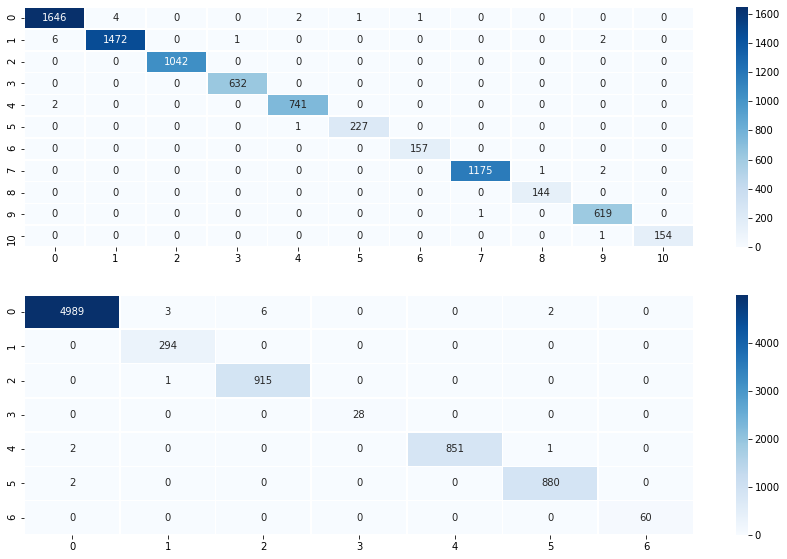

In [18]:
plot_final_confusion_matrices(valid_outputs, valid_targets)

In [19]:
def plot_acc_loss(train_acc, train_loss, valid_acc, valid_loss, epochs=20):
    epochs = [i+1 for i in range(epochs)]
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].plot(epochs, train_loss, "-b", label="training")
    ax[0].plot(epochs, valid_loss, "-r", label="validation")
    ax[0].set_title('loss')
    ax[0].legend(loc="upper center")
    
    
    ax[1].plot(epochs, train_acc, "-b", label="training")
    ax[1].plot(epochs, valid_acc, "-r", label="validation")
    ax[1].set_title('acc')
    ax[1].legend(loc="upper center")

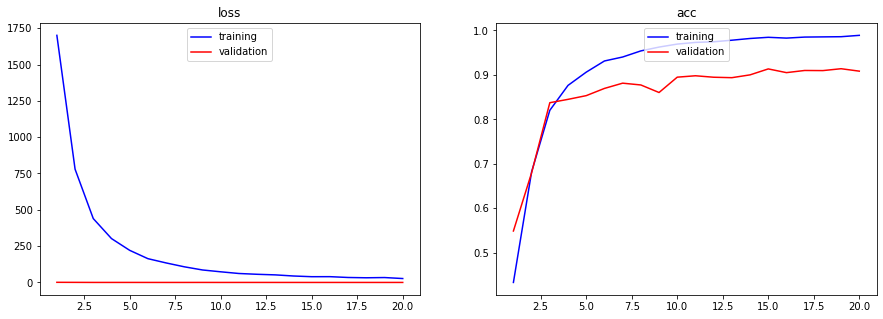

In [21]:
plot_acc_loss(train_accs[:20], train_losses[:20], valid_accs[:20], valid_losses[:20])

In [22]:
resnet_34 = ResNet34(True).to(device)
optimizer = torch.optim.Adam(resnet_34.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                        mode="min", 
                                                        patience=5, 
                                                        factor=0.3,verbose=True)

In [24]:
train_accs_pretrained, train_losses_pretrained, valid_accs_pretrained,\
    valid_losses_pretrained, train_outputs_1, train_targets_1, \
    valid_outputs_1, valid_targets_1 = run_model(resnet_34, 
    optimizer, criterion, scheduler, folds=3, train_batch_size=32, validation_batch_size=32)

folds 1/3 
epochs 1/20 



recall: grapheme 0.5525962891301774, vowel 0.8831766835639461, consonant 0.9051625207121511, total 0.723382945634113, y (32135, 3)
recall score : 0.7234
train loss : 1.0068



recall: grapheme 0.7250200272886002, vowel 0.9469729927639875, consonant 0.9579840695585797, total 0.8387492792249418, y (8033, 3)
recall score : 0.8387
validation loss : 0.3807
epochs 1/20 completed
epochs 2/20 



recall: grapheme 0.8389470615276706, vowel 0.9622905727186211, consonant 0.961075689463555, total 0.9003150963093793, y (32135, 3)
recall score : 0.9003
train loss : 0.2854



recall: grapheme 0.8736523136164407, vowel 0.9524583107244408, consonant 0.9462579632145196, total 0.9115052252929605, y (8033, 3)
recall score : 0.9115
validation loss : 0.2394
epochs 2/20 completed
epochs 3/20 



recall: grapheme 0.905348731175909, vowel 0.9795113627363176, consonant 0.9704111061994808, total 0.940154982821904, y (32135, 3)
recall score : 0.9402
train loss : 0.1556



recall: grapheme 0.9107759619542797, vowel 0.9697105608175204, consonant 0.963333294560799, total 0.9386489448217197, y (8033, 3)
recall score : 0.9386
validation loss : 0.1906
epochs 3/20 completed
epochs 4/20 



recall: grapheme 0.9351231080368685, vowel 0.9846796015287885, consonant 0.9792926481093505, total 0.958554616427969, y (32135, 3)
recall score : 0.9586
train loss : 0.1077



recall: grapheme 0.8898209783320778, vowel 0.9673707436838448, consonant 0.9507452691196168, total 0.9244394923669044, y (8033, 3)
recall score : 0.9244
validation loss : 0.2029
epochs 4/20 completed
epochs 5/20 



recall: grapheme 0.9540646997924298, vowel 0.9884556519601234, consonant 0.9825688491521654, total 0.9697884751742871, y (32135, 3)
recall score : 0.9698
train loss : 0.0749



recall: grapheme 0.8934952852269844, vowel 0.9640749718784103, consonant 0.961370463780538, total 0.9281090015282293, y (8033, 3)
recall score : 0.9281
validation loss : 0.1995
epochs 5/20 completed
epochs 6/20 



recall: grapheme 0.9636622921768959, vowel 0.98970929390774, consonant 0.9854359313266929, total 0.9756174523970562, y (32135, 3)
recall score : 0.9756
train loss : 0.0622



recall: grapheme 0.9022253282993741, vowel 0.9689816971800358, consonant 0.9687232119661325, total 0.935538891436229, y (8033, 3)
recall score : 0.9355
validation loss : 0.2156
epochs 6/20 completed
epochs 7/20 



recall: grapheme 0.9702455305437327, vowel 0.9898607173830669, consonant 0.9865661506520116, total 0.979229482280636, y (32135, 3)
recall score : 0.9792
train loss : 0.0509



recall: grapheme 0.9144018621744362, vowel 0.9638589404604094, consonant 0.9690340696966125, total 0.9404241836264736, y (8033, 3)
recall score : 0.9404
validation loss : 0.1827
epochs 7/20 completed
epochs 8/20 



recall: grapheme 0.975699493323384, vowel 0.9925527085427521, consonant 0.9877912176942226, total 0.9829357282209358, y (32135, 3)
recall score : 0.9829
train loss : 0.0416



recall: grapheme 0.8986518606340806, vowel 0.9593235924104934, consonant 0.9392043721102727, total 0.9239579214472318, y (8033, 3)
recall score : 0.9240
validation loss : 0.2028
epochs 8/20 completed
epochs 9/20 



recall: grapheme 0.9780780388702432, vowel 0.9933858186120531, consonant 0.9910938278779338, total 0.9851589310576183, y (32135, 3)
recall score : 0.9852
train loss : 0.0390



recall: grapheme 0.9048333546113709, vowel 0.9674294422872165, consonant 0.9437655958565766, total 0.9302154368416338, y (8033, 3)
recall score : 0.9302
validation loss : 0.2070
epochs 9/20 completed
epochs 10/20 



recall: grapheme 0.9826973696777335, vowel 0.9920773246730675, consonant 0.9949116210046266, total 0.9880959212582903, y (32135, 3)
recall score : 0.9881
train loss : 0.0327



recall: grapheme 0.9104607621951123, vowel 0.9729499527138739, consonant 0.9597432866520428, total 0.9384036909390354, y (8033, 3)
recall score : 0.9384
validation loss : 0.1992
epochs 10/20 completed
epochs 11/20 



recall: grapheme 0.9850529929740194, vowel 0.9936785327843659, consonant 0.9918501512670473, total 0.988908667499863, y (32135, 3)
recall score : 0.9889
train loss : 0.0306



recall: grapheme 0.9132139014288436, vowel 0.9712910184699678, consonant 0.9701700789035888, total 0.9419722250578109, y (8033, 3)
recall score : 0.9420
validation loss : 0.2041
epochs 11/20 completed
epochs 12/20 



recall: grapheme 0.9850813494443351, vowel 0.9952251603175856, consonant 0.9934721203981771, total 0.9897149949011081, y (32135, 3)
recall score : 0.9897
train loss : 0.0279



recall: grapheme 0.8898886365278984, vowel 0.9728298934373942, consonant 0.9552135206788332, total 0.926955171793006, y (8033, 3)
recall score : 0.9270
validation loss : 0.2278
epochs 12/20 completed
epochs 13/20 



recall: grapheme 0.987026945811205, vowel 0.9958784762460337, consonant 0.9951413947259466, total 0.9912684406485976, y (32135, 3)
recall score : 0.9913
train loss : 0.0248



recall: grapheme 0.9032826197497615, vowel 0.9576443277469338, consonant 0.9648201182563684, total 0.9322574213757063, y (8033, 3)
recall score : 0.9323
validation loss : 0.2132
Epoch    13: reducing learning rate of group 0 to 3.0000e-05.
epochs 13/20 completed
epochs 14/20 



recall: grapheme 0.9967012038280743, vowel 0.9984116365304391, consonant 0.9986630842330099, total 0.9976192821048994, y (32135, 3)
recall score : 0.9976
train loss : 0.0067



recall: grapheme 0.9284674373589031, vowel 0.9779871649284366, consonant 0.9702867597992794, total 0.9513021998613805, y (8033, 3)
recall score : 0.9513
validation loss : 0.1606
epochs 14/20 completed
epochs 15/20 



recall: grapheme 0.999629373130748, vowel 0.9998020506410973, consonant 0.9996697673955447, total 0.9996826410745345, y (32135, 3)
recall score : 0.9997
train loss : 0.0024



recall: grapheme 0.9314868946432033, vowel 0.9747316522237863, consonant 0.9683924261015443, total 0.9515244669029344, y (8033, 3)
recall score : 0.9515
validation loss : 0.1634
epochs 15/20 completed
epochs 16/20 



recall: grapheme 1.0, vowel 0.9999626990906769, consonant 0.999328867291804, total 0.9998228915956202, y (32135, 3)
recall score : 0.9998
train loss : 0.0014



recall: grapheme 0.9302917584107898, vowel 0.9781817268219579, consonant 0.9696935594585897, total 0.9521147007755318, y (8033, 3)
recall score : 0.9521
validation loss : 0.1626
epochs 16/20 completed
epochs 17/20 



recall: grapheme 0.9994248272609735, vowel 0.999502816902891, consonant 0.9988814851182235, total 0.9993084891357653, y (32135, 3)
recall score : 0.9993
train loss : 0.0025



recall: grapheme 0.9291358999811875, vowel 0.9768361220954347, consonant 0.9680831352057567, total 0.9507977643158916, y (8033, 3)
recall score : 0.9508
validation loss : 0.1857
epochs 17/20 completed
epochs 18/20 



recall: grapheme 0.9996881769471884, vowel 0.9998081278156835, consonant 0.9997816762705981, total 0.9997415394951646, y (32135, 3)
recall score : 0.9997
train loss : 0.0022



recall: grapheme 0.9362304352923557, vowel 0.9733789472216832, consonant 0.9613176805444154, total 0.9517893745877025, y (8033, 3)
recall score : 0.9518
validation loss : 0.1874
epochs 18/20 completed
epochs 19/20 



recall: grapheme 0.9993340201305188, vowel 0.9996862720337257, consonant 0.9988787545858785, total 0.9993082667201605, y (32135, 3)
recall score : 0.9993
train loss : 0.0034



recall: grapheme 0.9300959882666431, vowel 0.9767610482198162, consonant 0.9707404426214665, total 0.9519233668436422, y (8033, 3)
recall score : 0.9519
validation loss : 0.1816
epochs 19/20 completed
epochs 20/20 



recall: grapheme 0.9992503860411494, vowel 0.99975801581005, consonant 0.9995889472495445, total 0.9994619337854733, y (32135, 3)
recall score : 0.9995
train loss : 0.0029



recall: grapheme 0.9243181436680663, vowel 0.9767779725432408, consonant 0.9642734382331151, total 0.9474219245281221, y (8033, 3)
recall score : 0.9474
validation loss : 0.2020
Epoch    20: reducing learning rate of group 0 to 9.0000e-06.
epochs 20/20 completed
folds 1/3 completed
folds 2/3 
epochs 1/20 



recall: grapheme 0.9807122835076698, vowel 0.9946637987869447, consonant 0.9941353621854274, total 0.9875559319969279, y (32134, 3)
recall score : 0.9876
train loss : 0.0440



recall: grapheme 0.9980251342508625, vowel 1.0, consonant 1.0, total 0.9990125671254313, y (8034, 3)
recall score : 0.9990
validation loss : 0.0009
epochs 1/20 completed
epochs 2/20 



recall: grapheme 0.9916517185641719, vowel 0.9972215517605967, consonant 0.9963624207590381, total 0.9942218524119947, y (32134, 3)
recall score : 0.9942
train loss : 0.0169



recall: grapheme 0.9992288413341045, vowel 1.0, consonant 1.0, total 0.9996144206670523, y (8034, 3)
recall score : 0.9996
validation loss : 0.0007
epochs 2/20 completed
epochs 3/20 



recall: grapheme 0.9960594178703188, vowel 0.9983691312650117, consonant 0.9983010211582313, total 0.9971972470409701, y (32134, 3)
recall score : 0.9972
train loss : 0.0101



recall: grapheme 0.9999711049468332, vowel 1.0, consonant 0.9998383968972204, total 0.9999451516977217, y (8034, 3)
recall score : 0.9999
validation loss : 0.0007
epochs 3/20 completed
epochs 4/20 



recall: grapheme 0.9982156440508163, vowel 0.9988456103157393, consonant 0.9986953591454218, total 0.9984930643906985, y (32134, 3)
recall score : 0.9985
train loss : 0.0060



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0007
epochs 4/20 completed
epochs 5/20 



recall: grapheme 0.9993621840760596, vowel 0.9995335527707842, consonant 0.9997776717208033, total 0.9995088981609267, y (32134, 3)
recall score : 0.9995
train loss : 0.0037



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0005
epochs 5/20 completed
epochs 6/20 



recall: grapheme 0.9992706570077408, vowel 0.9997270585331189, consonant 0.9999856921084824, total 0.9995635161642706, y (32134, 3)
recall score : 0.9996
train loss : 0.0024



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0004
epochs 6/20 completed
epochs 7/20 



recall: grapheme 0.9998202804427214, vowel 0.999812873352769, consonant 0.9992831867870889, total 0.9996841552563253, y (32134, 3)
recall score : 0.9997
train loss : 0.0017



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0004
epochs 7/20 completed
epochs 8/20 



recall: grapheme 0.9997909567126846, vowel 0.9999862529727946, consonant 0.9998334232702886, total 0.9998503974171131, y (32134, 3)
recall score : 0.9999
train loss : 0.0013



recall: grapheme 1.0, vowel 0.999938450175417, consonant 1.0, total 0.9999846125438543, y (8034, 3)
recall score : 1.0000
validation loss : 0.0004
epochs 8/20 completed
epochs 9/20 



recall: grapheme 0.9999146144149721, vowel 0.9999701251755145, consonant 1.0, total 0.9999498385013647, y (32134, 3)
recall score : 0.9999
train loss : 0.0011



recall: grapheme 0.9995421245421244, vowel 0.999938450175417, consonant 1.0, total 0.9997556748149165, y (8034, 3)
recall score : 0.9998
validation loss : 0.0004
epochs 9/20 completed
epochs 10/20 



recall: grapheme 0.9997944292451131, vowel 0.9999079720423448, consonant 0.9999437116261884, total 0.9998601355396899, y (32134, 3)
recall score : 0.9999
train loss : 0.0013



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0003
epochs 10/20 completed
epochs 11/20 



recall: grapheme 0.9999775430875767, vowel 1.0, consonant 0.9999928456959707, total 0.999986982967781, y (32134, 3)
recall score : 1.0000
train loss : 0.0008



recall: grapheme 0.9995421245421244, vowel 0.9999450700357044, consonant 1.0, total 0.9997573297799883, y (8034, 3)
recall score : 0.9998
validation loss : 0.0003
epochs 11/20 completed
epochs 12/20 



recall: grapheme 0.9999482167618358, vowel 1.0, consonant 0.9999543497454095, total 0.9999626958172703, y (32134, 3)
recall score : 1.0000
train loss : 0.0007



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0002
epochs 12/20 completed
epochs 13/20 



recall: grapheme 0.9999228497770458, vowel 1.0, consonant 1.0, total 0.9999614248885229, y (32134, 3)
recall score : 1.0000
train loss : 0.0007



recall: grapheme 0.9995421245421244, vowel 1.0, consonant 1.0, total 0.9997710622710623, y (8034, 3)
recall score : 0.9998
validation loss : 0.0002
epochs 13/20 completed
epochs 14/20 



recall: grapheme 0.9998771135240405, vowel 0.9999862529727946, consonant 0.9999856921084824, total 0.9999315430323394, y (32134, 3)
recall score : 0.9999
train loss : 0.0006



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0002
epochs 14/20 completed
epochs 15/20 



recall: grapheme 0.9999315832472611, vowel 0.999931552990419, consonant 0.9999580325667282, total 0.9999381880129173, y (32134, 3)
recall score : 0.9999
train loss : 0.0007



recall: grapheme 1.0, vowel 0.9999128388390133, consonant 1.0, total 0.9999782097097534, y (8034, 3)
recall score : 1.0000
validation loss : 0.0003
epochs 15/20 completed
epochs 16/20 



recall: grapheme 0.9999877270495828, vowel 1.0, consonant 0.9998908881010212, total 0.9999665855500467, y (32134, 3)
recall score : 1.0000
train loss : 0.0006



recall: grapheme 0.9995421245421244, vowel 0.9999450700357044, consonant 0.9998450573287884, total 0.9997185941121854, y (8034, 3)
recall score : 0.9997
validation loss : 0.0005
epochs 16/20 completed
epochs 17/20 



recall: grapheme 1.0, vowel 1.0, consonant 0.9999928456959707, total 0.9999982114239927, y (32134, 3)
recall score : 1.0000
train loss : 0.0004



recall: grapheme 1.0, vowel 0.9999450700357044, consonant 1.0, total 0.9999862675089262, y (8034, 3)
recall score : 1.0000
validation loss : 0.0003
epochs 17/20 completed
epochs 18/20 



recall: grapheme 1.0, vowel 0.9999652886250825, consonant 0.9999580325667282, total 0.9999808302979527, y (32134, 3)
recall score : 1.0000
train loss : 0.0004



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0002
epochs 18/20 completed
epochs 19/20 



recall: grapheme 0.9999906113865104, vowel 0.9999862529727946, consonant 0.9999580325667282, total 0.999981377078136, y (32134, 3)
recall score : 1.0000
train loss : 0.0004



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0002
epochs 19/20 completed
epochs 20/20 



recall: grapheme 0.9996615038389213, vowel 0.99994087371822, consonant 0.9999856921084824, total 0.9998123933761363, y (32134, 3)
recall score : 0.9998
train loss : 0.0006



recall: grapheme 0.9996279761904762, vowel 0.9999450700357044, consonant 1.0, total 0.9998002556041642, y (8034, 3)
recall score : 0.9998
validation loss : 0.0004
epochs 20/20 completed
folds 2/3 completed
folds 3/3 
epochs 1/20 



recall: grapheme 0.999825406075406, vowel 1.0, consonant 0.9999928460542412, total 0.9999109145512634, y (32134, 3)
recall score : 0.9999
train loss : 0.0004



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 1/20 completed
epochs 2/20 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




recall: grapheme 1.0, vowel 1.0, consonant 0.9999928460542412, total 0.9999982115135603, y (32134, 3)
recall score : 1.0000
train loss : 0.0002



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 5/20 completed
epochs 6/20 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




recall: grapheme 1.0, vowel 0.999980360965455, consonant 0.9993416721527321, total 0.9998305082795467, y (32134, 3)
recall score : 0.9998
train loss : 0.0002



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 9/20 completed
epochs 10/20 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 12/20 completed
epochs 13/20 



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0001



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 13/20 completed
epochs 14/20 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




recall: grapheme 0.9999915328862696, vowel 1.0, consonant 0.9999522266618913, total 0.9999838231086077, y (32134, 3)
recall score : 1.0000
train loss : 0.0002



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 16/20 completed
epochs 17/20 



recall: grapheme 1.0, vowel 0.9999707611866022, consonant 1.0, total 0.9999926902966505, y (32134, 3)
recall score : 1.0000
train loss : 0.0002



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 17/20 completed
epochs 18/20 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (32134, 3)
recall score : 1.0000
train loss : 0.0001



recall: grapheme 1.0, vowel 1.0, consonant 1.0, total 1.0, y (8034, 3)
recall score : 1.0000
validation loss : 0.0000
epochs 20/20 completed
folds 3/3 completed


In [25]:
save_metrics(train_accs_pretrained, train_losses_pretrained, valid_accs_pretrained, valid_losses_pretrained, "../data/resnet_34_pretrained.csv")


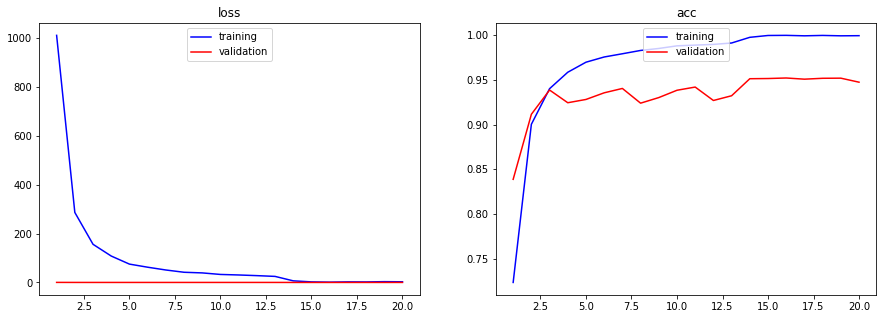

In [26]:
plot_acc_loss(train_accs_pretrained[:20], train_losses_pretrained[:20], valid_accs_pretrained[:20], valid_losses_pretrained[:20])

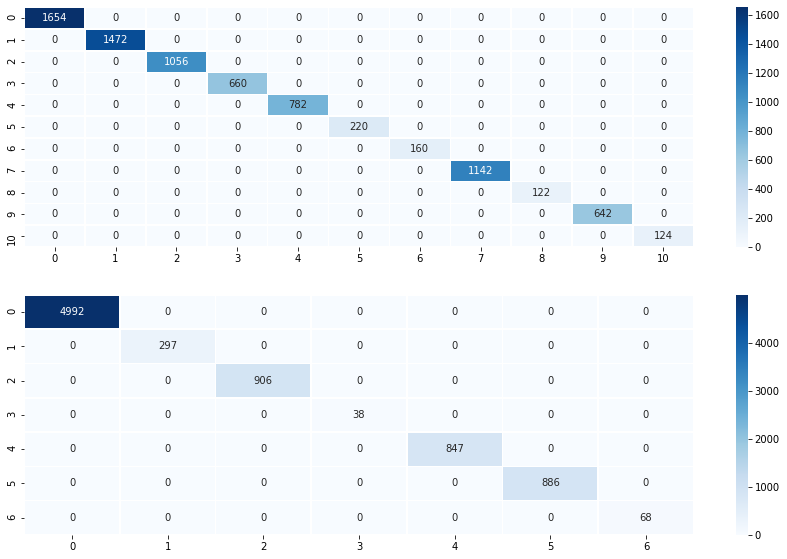

In [27]:
plot_final_confusion_matrices(valid_outputs_1, valid_targets_1)